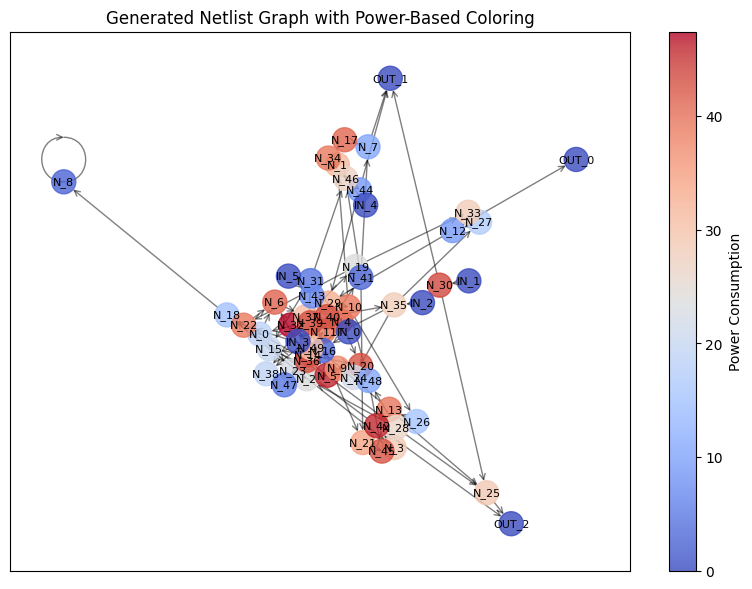

In [7]:
import networkx as nx
import numpy as np
import math
import random
import matplotlib.pyplot as plt # Import matplotlib.pyplot and alias it as plt

def generate_netlist(
    num_nodes=50,
    num_edges=100,
    enable_area=True,
    #Area (chip constraints) of the node or the gate assembly
    enable_power=True,
    # Power consumption of the gate (used to optimize or reduce heat generation or power consumption per chip)
    enable_wire_count=True,
    # Number of wires represented by an edge
    enable_distance=True,
    # Distance of the wire to calculate power dissipation and delay
    seed = None
):
    """Generates a netlist as a directed graph with specific connectivity constraints."""
    if seed:
        random.seed(seed)
        np.random.seed(seed)
    #Generate a directed graph
    G = nx.DiGraph()

    # Estimate number of inputs and outputs
    # Assuming num_inputs and num_outputs to be the functions below
    num_inputs = math.ceil(math.log2(num_nodes))
    num_outputs = math.ceil(num_inputs / 2)
    input_nodes = [f"IN_{i}" for i in range(num_inputs)]
    output_nodes = [f"OUT_{i}" for i in range(num_outputs)]
    internal_nodes = [f"N_{i}" for i in range(num_nodes)]

    # Create internal nodes with attributes
    # Area carying from A to 5A
    # Power Consumption varying from P to 50P
    for node in internal_nodes:
        G.add_node(node)
        if enable_area:
            G.nodes[node]['area'] = round(random.uniform(1.0, 5.0), 2)
        if enable_power:
            G.nodes[node]['power'] = round(random.uniform(1.0, 50.0), 2)

    # Create input and output nodes
    for node in input_nodes + output_nodes:
        G.add_node(node)

    # Ensure input nodes have at least one outgoing edge
    for input_node in input_nodes:
        target = random.choice(internal_nodes)
        G.add_edge(input_node, target)

    # Ensure output nodes have exactly one incoming edge
    for output_node in output_nodes:
        source = random.choice(internal_nodes)
        G.add_edge(source, output_node)

    # Ensure internal nodes have at least one incoming and one outgoing edge
    # i.e. no gate is useless in the circuit
    for node in internal_nodes:
        if G.in_degree(node) == 0:
            source = random.choice(input_nodes + internal_nodes)
            G.add_edge(source, node)
        if G.out_degree(node) == 0:
            target = random.choice(internal_nodes + output_nodes)
            G.add_edge(node, target)

    # Add additional edges up to num_edges while preventing duplicate edges and self-loops
    existing_edges = set(G.edges())
    while len(G.edges()) < num_edges:
        u, v = random.sample(internal_nodes, 2)
        if u != v and (u, v) not in existing_edges:
            G.add_edge(u, v)
            existing_edges.add((u, v))

    # Assign edge attributes
    for u, v in G.edges():
        if enable_wire_count:
            G.edges[u, v]['wires'] = random.randint(1, 5)
        if enable_distance:
            G.edges[u, v]['distance'] = round(random.uniform(1.0, 10.0), 2)

    return G, input_nodes, output_nodes


def visualize_netlist(G):
    pos = nx.spring_layout(G, seed=42)
    power_values = [G.nodes[n].get('power', 0) for n in G.nodes()]

    plt.figure(figsize=(10, 7)) # Call plt.figure to create a new figure
    nodes = nx.draw_networkx_nodes(G, pos, node_color=power_values, cmap='coolwarm', alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5, arrowstyle='->', arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)

    cbar = plt.colorbar(nodes)
    cbar.set_label("Power Consumption")
    plt.title("Generated Netlist Graph with Power-Based Coloring")
    plt.show()

# Example usage
graph, inputs, outputs = generate_netlist(num_nodes=50, num_edges=100)
visualize_netlist(graph)

In [8]:
def find_critical_path(G, distance_factor=1.0, gate_delay_factor=0.5):
    """
    Finds the critical path (longest delay path) in the netlist.

    Parameters:
    - G: Graph in netlist format
    - distance_factor: Scaling factor for wire delay.
    - gate_delay_factor: Scaling factor for gate delay.
      May be set to zero if we run model for large networks.

    Returns:
    - critical_path: List of nodes in the longest path.
    - critical_delay: Total delay along the critical path.
    """
    # Work on a copy of G to avoid modifying the original
    # We do so because we need to make it a DAG to allow topological sorting to work
    # Since only the heavy edges would contribute to delay, we keep the heavier edge only
    G_copy = G.copy()

    # Detect and break all cycles
    while not nx.is_directed_acyclic_graph(G_copy):
        try:
            cycle = next(nx.simple_cycles(G_copy))  # Get a cycle
            # Find the edge with minimum weight
            min_edge = min(
                ((cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))),
                key=lambda e: G_copy.edges[e].get("distance", 1)
            )  # Find the edge with smallest weight and remove it, breaking the cycle
            G_copy.remove_edge(*min_edge)
            # Temporary print stmnt.
            #print(f"Removed edge {min_edge} to break cycle.")
        except StopIteration:
            break  # No more cycles

    # Assign delays to edges i.e. make a dictionary.
    edge_delays = {
        (u, v): (G_copy[u][v].get("distance", 1) **2) * distance_factor +
                 G_copy.nodes[v].get("area", 1) * gate_delay_factor
        for u, v in G_copy.edges()
    }

    # Compute longest path using topological sorting + DP
    # Used nx library
    top_order = list(nx.topological_sort(G_copy))
    longest_path = {node: (0, None) for node in G_copy.nodes()}  # {node: (max_delay, prev_node)}

    # now finding the longest path
    for node in top_order:
      #For every node, we loop through outgoing neighbours
        for succ in G_copy.successors(node):
          # new delay if we go from node to its successor
            new_delay = longest_path[node][0] + edge_delays.get((node, succ), 1)
            if new_delay > longest_path[succ][0]:
                longest_path[succ] = (new_delay, node)

    # Find the endpoint of the longest path
    end_node = max(longest_path, key=lambda n: longest_path[n][0])
    critical_delay = longest_path[end_node][0]

    # Reconstruct the critical path by backtracking from the end_node
    critical_path = []
    while end_node is not None:
        critical_path.append(end_node)
        end_node = longest_path[end_node][1]

    critical_path.reverse()  # Reverse to get correct order
    return critical_path, critical_delay

In [9]:
# Example
graph, inputs, outputs = generate_netlist(num_nodes=50, num_edges=100)
critical_path, delay = find_critical_path(graph)
print("Critical Path:", " → ".join(critical_path))
print("Total Critical Path Delay:", delay)

Critical Path: N_9 → N_29 → N_16 → N_35 → N_17 → N_36 → N_49 → N_30 → N_42 → N_7 → N_28 → N_37 → N_11 → N_8 → N_6
Total Critical Path Delay: 680.0432000000001
